In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from utils.attack_algo_utils import *
from utils.graph_utils import *
from utils.utils import *

In [2]:
# --- CHỌN PHIÊN BẢN THÍ NGHIỆM ---
experiment_id = 1
BASE_PATH = f'graphs/{experiment_id}'

In [3]:
# --- LOAD ENVIRONMENTAL INFORMATION ---

import torch
import networkx as nx
import numpy as np

# --- 1. Tải Môi trường (Tĩnh) ---
STATIC_FILE_PATH = f"{BASE_PATH}/graph_environment.pth"

try:
    env_data = torch.load(STATIC_FILE_PATH)

    G = env_data['G_original']
    node_order = env_data['node_order']
    node_map = env_data['node_map']

    # Bạn cũng có thể lấy features gốc nếu cần
    # node_features_goc = env_data['node_features_original']

    print(f"--- Đã tải môi trường tĩnh từ '{STATIC_FILE_PATH}' ---")
    print("Tổng số node:", len(node_order))
    print("Map của 'Host 1':", node_map['Host 1'])

except FileNotFoundError:
    print(f"LỖI: Không tìm thấy tệp '{STATIC_FILE_PATH}'.")
    print("Vui lòng kiểm tra lại experiment_id hoặc đường dẫn.")
    # Thoát hoặc xử lý lỗi nếu cần
    exit()


# --- 2. Tải Embeddings (Động) ---
NODE_EMB_PATH = f"{BASE_PATH}/node_embeddings.npy"
EDGE_EMB_PATH = f"{BASE_PATH}/edge_embeddings.npy"

try:
    nodes_emb = np.load(NODE_EMB_PATH)
    edges_emb = np.load(EDGE_EMB_PATH)

    print(f"\n--- Đã tải embedding động từ thí nghiệm {experiment_id} ---")
    print("Shape của Node Embeddings:", nodes_emb.shape)

except FileNotFoundError:
    print(f"LỖI: Không tìm thấy tệp '{NODE_EMB_PATH}' hoặc '{EDGE_EMB_PATH}'.")
    # Thoát hoặc xử lý lỗi nếu cần
    exit()


# --- 3. Sử dụng ---
# Giờ đây bạn đã có cả hai:
# - `node_map` để biết "Host 1" là ID số mấy.
# - `nodes_emb` để lấy embedding của ID đó.

try:
    node_name = "Host 1"
    node_id = node_map[node_name]
    embedding_cua_host_1 = nodes_emb[node_id]

    print(f"\n--- Sẵn sàng cho RL ---")
    print(f"Embedding cho '{node_name}' (ID: {node_id}): \n", embedding_cua_host_1)

except KeyError:
    print(f"Lỗi: Không tìm thấy node '{node_name}' trong node_map.")
except IndexError:
    print(f"Lỗi: node_id {node_id} nằm ngoài phạm vi của 'nodes_emb' (Shape: {nodes_emb.shape})")

--- Đã tải môi trường tĩnh từ 'graphs/1/graph_environment.pth' ---
Tổng số node: 7
Map của 'Host 1': 3

--- Đã tải embedding động từ thí nghiệm 1 ---
Shape của Node Embeddings: (7, 8)

--- Sẵn sàng cho RL ---
Embedding cho 'Host 1' (ID: 3): 
 [ 7.2375193e-02 -3.1381101e-06 -1.7758512e-03 -8.0107589e-04
 -1.3138228e-03  5.4618120e-03 -8.5612241e-04 -1.2267809e-03]


/tmp/ipykernel_95478/1848957384.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  env_data = torch.load(STATIC_FILE_PATH)


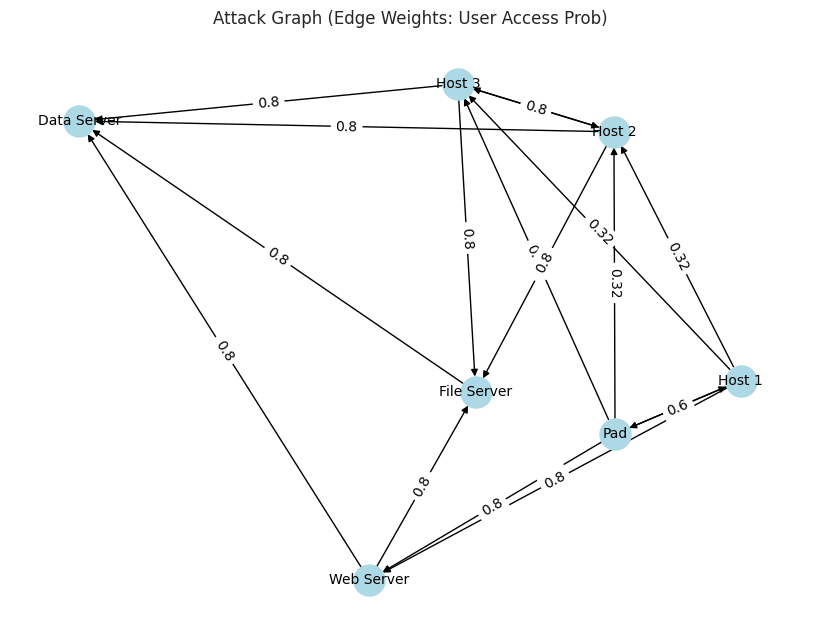

In [4]:
# --- Visualize the graph ---
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'user')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Attack Graph (Edge Weights: User Access Prob)")
plt.show()

In [5]:
print(nodes_emb)

[[ 1.34134144e-01  1.48097016e-02 -1.57403061e-03 -8.46673502e-04
  -5.49352262e-04 -2.52334023e-04 -4.97509958e-04  1.51329339e-02]
 [ 9.46847051e-02  4.96009737e-03 -1.27501844e-03 -7.33968918e-04
  -1.12035766e-03  1.63555443e-02 -1.30758039e-03 -6.91983209e-04]
 [ 1.07669726e-01 -1.85593730e-04 -1.30563939e-03 -1.21417013e-03
  -2.08980590e-03  1.40457898e-02 -9.44370579e-04 -8.18924862e-04]
 [ 7.23751932e-02 -3.13811006e-06 -1.77585124e-03 -8.01075890e-04
  -1.31382281e-03  5.46181202e-03 -8.56122409e-04 -1.22678094e-03]
 [ 4.86400165e-03  7.68652931e-02 -1.81507668e-03 -4.96621127e-04
  -7.37447699e-04  1.43692002e-01 -1.53517746e-03 -1.56256615e-03]
 [ 1.02416687e-02  7.89749250e-02 -2.06100941e-03  4.19706851e-02
  -2.62125250e-04  1.85343400e-01 -1.98430638e-03 -1.55183370e-03]
 [ 2.77794376e-02  5.56039363e-02 -1.55620486e-03 -3.02736153e-04
  -1.41924096e-03  1.63817421e-01 -1.90122263e-03 -1.08237739e-03]]


In [6]:
print(edges_emb)

[[ 0.03175435 -0.00049867  0.13122845  0.12103277 -0.00134934  0.0205301
  -0.00129126  0.08789697]
 [ 0.04138342 -0.00045631  0.12362889  0.12830746 -0.0014224   0.02068803
  -0.00126208  0.08590298]
 [ 0.05751536 -0.00049414  0.13854909  0.15632692 -0.00153068  0.05735978
  -0.00107006  0.10889359]
 [ 0.04648215 -0.00058182  0.14208111  0.15228987 -0.00149143  0.05425903
  -0.00110614  0.10707353]
 [ 0.03163068 -0.00053164  0.12229879  0.13252911 -0.00135646  0.02060157
  -0.00121077  0.07706802]
 [ 0.02143168 -0.00049322  0.13012697  0.1221641  -0.0012434   0.02319412
  -0.00125136  0.0790247 ]
 [ 0.02250049 -0.0007871   0.10796165  0.17091271 -0.00109383  0.10379077
  -0.00041039  0.05932743]
 [ 0.02434926 -0.00070921  0.10967083  0.1711818  -0.00116812  0.09361575
  -0.00051372  0.06097565]
 [ 0.01925053 -0.00058371  0.09121861  0.14719939 -0.0010991   0.06004475
  -0.00066966  0.03980511]
 [ 0.03538247 -0.00062154  0.1061388   0.17521885 -0.00120737  0.09671649
  -0.00047764  0.0

In [7]:
# ======================================================================
# TẢI DỮ LIỆU MÔI TRƯỜNG TĨNH
# ======================================================================
print("--- Đang tải dữ liệu môi trường (tĩnh) ---")
env_data = torch.load(f"{BASE_PATH}/graph_environment.pth")

# Giả sử bạn đã lưu 'g_dgl' trong file .pth
# Nếu không, bạn cần tải 'G_original' và tạo lại g_dgl
g_dgl = env_data.get('g_dgl')
if g_dgl is None:
    # Nếu bạn chỉ lưu G_original, hãy tạo lại g_dgl
    G_original = env_data['G_original']
    g_dgl = dgl.from_networkx(G_original, node_attrs=['state', 'priority'], edge_attrs=['user', 'root'])
    # Gán lại features gốc (rất quan trọng)
    g_dgl.ndata['h'] = env_data['node_features_original']
    g_dgl.edata['h'] = env_data['edge_features_original']
    print("Đã tạo lại g_dgl từ G_original.")

original_edge_features = env_data['edge_features_original']
original_node_features = env_data['node_features_original']
static_priority_features = original_node_features[:, 1].unsqueeze(1) # Cột priority

print("[THÀNH CÔNG] Đã tải xong dữ liệu môi trường.")

# ======================================================================
# TẢI MODEL GNN ĐÃ HUẤN LUYỆN (Code của bạn ở đây)
# ======================================================================
print("--- Đang tải cấu hình và trọng số GNN ---")

MODEL_STATE_PATH = f"{BASE_PATH}/dgi_model_state_dict.pth"
CONFIG_FILE_PATH = f"{BASE_PATH}/model_config.pth"

try:
    # --- 3.1: Tải file cấu hình ---
    config = torch.load(CONFIG_FILE_PATH)
    print(f"Đã tải cấu hình: {config}")

    # --- 3.2: Khởi tạo mô hình rỗng TỪ CẤU HÌNH ĐÃ TẢI ---
    encoder = EGraphSAGE(
        config['NDIM_IN'],
        config['EDIM'],
        config['N_HIDDEN'],
        config['N_OUT'],
        config['N_LAYERS'],
        F.leaky_relu
    )

    dgi_model_to_load = DGI(encoder)

    # --- 3.3: Tải trọng số đã lưu ---
    dgi_model_to_load.load_state_dict(torch.load(MODEL_STATE_PATH))

    # --- 3.4: Trích xuất encoder bạn cần ---
    trained_encoder = dgi_model_to_load.encoder
    trained_encoder.eval() # Chuyển sang chế độ dự đoán

    print(f"[THÀNH CÔNG] Đã tải và trích xuất GNN encoder.")

except Exception as e:
    print(f"\n[LỖI] Có lỗi xảy ra khi tải model: {e}")
    trained_encoder = None

--- Đang tải dữ liệu môi trường (tĩnh) ---
Đã tạo lại g_dgl từ G_original.
[THÀNH CÔNG] Đã tải xong dữ liệu môi trường.
--- Đang tải cấu hình và trọng số GNN ---
Đã tải cấu hình: {'NDIM_IN': 2, 'EDIM': 2, 'N_HIDDEN': 16, 'N_OUT': 24, 'N_LAYERS': 2}
[THÀNH CÔNG] Đã tải và trích xuất GNN encoder.


/tmp/ipykernel_95478/1988763365.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  env_data = torch.load(f"{BASE_PATH}/graph_environment.pth")
/tmp/ipykernel_95478/19887633

In [8]:
# def train_dqn(env, num_episodes, batch_size=10, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
#     global best_checkpoint, best_episode
#     state_size = env.num_nodes
#     action_space_size = env.get_action_space_size()
#     print('state_size', state_size)
#     print('action_space_size', action_space_size)
#     # Initialize DQN and target network
#     policy_net = DQN(state_size, action_space_size)
#     target_net = DQN(state_size, action_space_size)
#     target_net.load_state_dict(policy_net.state_dict())
#     target_net.eval()
#
#     optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
#     replay_buffer = ReplayBuffer(capacity=10000)
#     epsilon = epsilon_start
#     total_reward = 0
#     dsp = 0
#     best_dsp = 0
#     interval_check = num_episodes // 10  # Mỗi num_episodes/10
#     interval_save = num_episodes // 5   # Lưu sau mỗi num_episodes/5
#
#     for episode in range(1, num_episodes+1):
#         state = env.reset()
#         done = False
#
#         exploration_counter = defaultdict(int)
#
#         while not done:
#             if random.random() < epsilon:
#                 # Chọn ngẫu nhiên index hợp lệ
#                 action_idx = sample_valid_index(action_space_size, env.num_honeypot_nodes, exploration_counter)
#             else:
#                 with torch.no_grad():
#                     state_tensor = torch.FloatTensor(state).unsqueeze(0)
#                     q_values = policy_net(state_tensor).squeeze(0)  # shape: [action_space_size]
#
#                     # Lọc q_values chỉ lấy index hợp lệ
#                     valid_indices = [idx for idx in range(action_space_size) if is_valid_index(idx, env.num_honeypot_nodes)]
#                     valid_q_values = q_values[valid_indices]
#                     # Lấy chỉ số trong valid_indices có q_value max
#                     max_idx_in_valid = torch.argmax(valid_q_values).item()
#                     # Map về action_idx thực
#                     action_idx = valid_indices[max_idx_in_valid]
#
#             action = index_to_action(action_idx, env.num_honeypot_nodes)
#             next_state, reward, done, path, captured = env.step(action)
#             action_idx = action_to_index(action, env.num_honeypot_nodes)
#
#             # Store experience
#             replay_buffer.push(state, action_idx, reward, next_state, done)
#             state = next_state
#             total_reward += reward
#             if reward == 1:
#                 dsp += 1
#             # Train if enough experiences
#             if len(replay_buffer) >= batch_size:
#                 states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
#
#                 states = torch.FloatTensor(states)
#                 actions = torch.LongTensor(actions)
#                 rewards = torch.FloatTensor(rewards)
#                 next_states = torch.FloatTensor(next_states)
#                 dones = torch.FloatTensor(dones)
#
#                 # Compute Q-values
#                 q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
#
#                 # Compute target Q-values
#                 with torch.no_grad():
#                     next_q_values = target_net(next_states).max(1)[0]
#                     targets = rewards + (1 - dones) * gamma * next_q_values
#
#                 # Compute loss
#                 loss = nn.MSELoss()(q_values, targets)
#
#                 # Optimize
#                 optimizer.zero_grad()
#                 loss.backward()
#                 optimizer.step()
#
#         # Update target network
#         if episode % 10 == 0:
#             target_net.load_state_dict(policy_net.state_dict())
#
#         # Decay epsilon
#         epsilon = max(epsilon_end, epsilon * epsilon_decay)
#
#         # Logging
#         if episode % interval_check == 0:
#             placement = []
#             for i in range(2):  # Two honeypots
#                 node_idx = np.argmax(action[i])
#                 node_name = env.honeypot_nodes[node_idx]
#                 placement.append(f"Honeypot {i} -> {node_name}\n")
#             print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Defense Success Probability: {dsp/interval_check}%\n")
#             print("".join(placement))
#             print(path)
#             total_reward = 0
#
#             # Log ra DSP lớn nhất sau mỗi num_episodes/10 iterations
#             if dsp > best_dsp:
#                 best_dsp = dsp
#                 best_episode = episode
#                 best_checkpoint = {
#                     'policy_net_state_dict': deepcopy(policy_net.state_dict()),
#                     'target_net_state_dict': deepcopy(target_net.state_dict()),
#                     'optimizer_state_dict': deepcopy(optimizer.state_dict()),
#                 }
#             # Reset DSP
#             dsp = 0
#
#
#         # Save ra DSP lớn nhất sau mỗi num_episodes/5 iterations
#         if (episode + 1) % interval_save == 0 and best_checkpoint is not None:
#             path = f'./Saved_Model/dqn_model.pth'
#             torch.save({
#                 'policy_net_state_dict': best_checkpoint['policy_net_state_dict'],
#                 'target_net_state_dict': best_checkpoint['target_net_state_dict'],
#                 'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
#                 'episode': best_episode},
#                 path)
#             print(f'Saved model with best DSP {best_dsp} at episode {best_episode} to {path}')
#
#             best_dsp = 0
#             best_episode = 0
#             best_checkpoint = None
#
#     return policy_net

In [9]:
def train_dqn(env, num_episodes, batch_size=10, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
    global best_checkpoint, best_episode
    # 1. Reset env để lấy state (embedding) ban đầu
    state = env.reset() # state giờ là Tensor [num_nodes, embedding_dim]

    # 2. Tính toán state_size đã làm phẳng
    num_nodes = state.shape[0]
    embedding_dim = state.shape[1]
    state_size = num_nodes * embedding_dim  # <--- Kích thước input mới cho DQN

    action_space_size = env.get_action_space_size()

    print('state_size (flattened):', state_size) # <--- Cập nhật log
    print('action_space_size', action_space_size)

    # 3. Khởi tạo DQN với state_size mới
    policy_net = DQN(state_size, action_space_size)
    target_net = DQN(state_size, action_space_size)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=0.001)
    replay_buffer = ReplayBuffer(capacity=10000)
    epsilon = epsilon_start
    total_reward = 0
    dsp = 0
    best_dsp = 0
    interval_check = num_episodes // 10
    interval_save = num_episodes // 5

    for episode in range(1, num_episodes + 1):
        # Reset state cho các episode sau
        if episode > 1:
            state = env.reset() # <--- state là Tensor embedding

        done = False
        exploration_counter = defaultdict(int)

        while not done:
            if random.random() < epsilon:
                action_idx = sample_valid_index(action_space_size, env.num_honeypot_nodes, exploration_counter)
            else:
                with torch.no_grad():
                    # --- THAY ĐỔI: Flatten state tensor ---
                    # Chuyển [N, D] -> [1, N*D]
                    state_tensor = state.flatten().unsqueeze(0)
                    q_values = policy_net(state_tensor).squeeze(0)

                    # (Logic lọc q_values giữ nguyên)
                    valid_indices = [idx for idx in range(action_space_size) if is_valid_index(idx, env.num_honeypot_nodes)]
                    valid_q_values = q_values[valid_indices]
                    max_idx_in_valid = torch.argmax(valid_q_values).item()
                    action_idx = valid_indices[max_idx_in_valid]

            action = index_to_action(action_idx, env.num_honeypot_nodes)

            # --- next_state giờ cũng là Tensor embedding ---
            next_state, reward, done, path, captured = env.step(action)
            action_idx = action_to_index(action, env.num_honeypot_nodes)

            # Store experience (state và next_state là Tensors)
            replay_buffer.push(state, action_idx, reward, next_state, done)
            state = next_state
            total_reward += reward
            if reward == 1:
                dsp += 1

            # Train if enough experiences
            if len(replay_buffer) >= batch_size:
                # --- THAY ĐỔI: Replay buffer giờ trả về Tensors ---
                states_batch, actions_batch, rewards_batch, next_states_batch, dones_batch = replay_buffer.sample(batch_size)

                # states_batch là [B, N, D], actions_batch là [B], rewards_batch là [B, 1], ...

                # --- THAY ĐỔI: Flatten state batches ---
                # Chuyển [B, N, D] -> [B, N*D]
                states_flat = states_batch.flatten(start_dim=1)
                next_states_flat = next_states_batch.flatten(start_dim=1)

                # Compute Q-values
                q_values_all = policy_net(states_flat)
                # Dùng actions_batch để lấy Q-value của action đã chọn
                q_values = q_values_all.gather(1, actions_batch.long().unsqueeze(1)).squeeze(1)

                # Compute target Q-values
                with torch.no_grad():
                    # Dùng next_states_flat
                    next_q_values = target_net(next_states_flat).max(1)[0]
                    # Squeeze rewards và dones để khớp kích thước [B]
                    targets = rewards_batch.squeeze(1) + (1 - dones_batch.squeeze(1)) * gamma * next_q_values

                # Compute loss
                loss = nn.MSELoss()(q_values, targets)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if episode % 10 == 0:
            target_net.load_state_dict(policy_net.state_dict())

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # Logging (Giữ nguyên)
        if episode % interval_check == 0:
            placement = []
            for i in range(2):
                node_idx = np.argmax(action[i])
                node_name = env.honeypot_nodes[node_idx]
                placement.append(f"Honeypot {i} -> {node_name}\n")
            print(f"Episode {episode}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}, Defense Success Probability: {dsp/interval_check}%\n")
            print("".join(placement))
            print(path)
            total_reward = 0

            if dsp > best_dsp:
                best_dsp = dsp
                best_episode = episode
                best_checkpoint = {
                    'policy_net_state_dict': deepcopy(policy_net.state_dict()),
                    'target_net_state_dict': deepcopy(target_net.state_dict()),
                    'optimizer_state_dict': deepcopy(optimizer.state_dict()),
                }
            dsp = 0

        # Save (Giữ nguyên)
        if (episode + 1) % interval_save == 0 and best_checkpoint is not None:
            path = f'./Saved_Model/dqn_model.pth'
            torch.save({
                'policy_net_state_dict': best_checkpoint['policy_net_state_dict'],
                'target_net_state_dict': best_checkpoint['target_net_state_dict'],
                'optimizer_state_dict': best_checkpoint['optimizer_state_dict'],
                'episode': best_episode},
                path)
            print(f'Saved model with best DSP {best_dsp} at episode {best_episode} to {path}')

            best_dsp = 0
            best_episode = 0
            best_checkpoint = None

    return policy_net

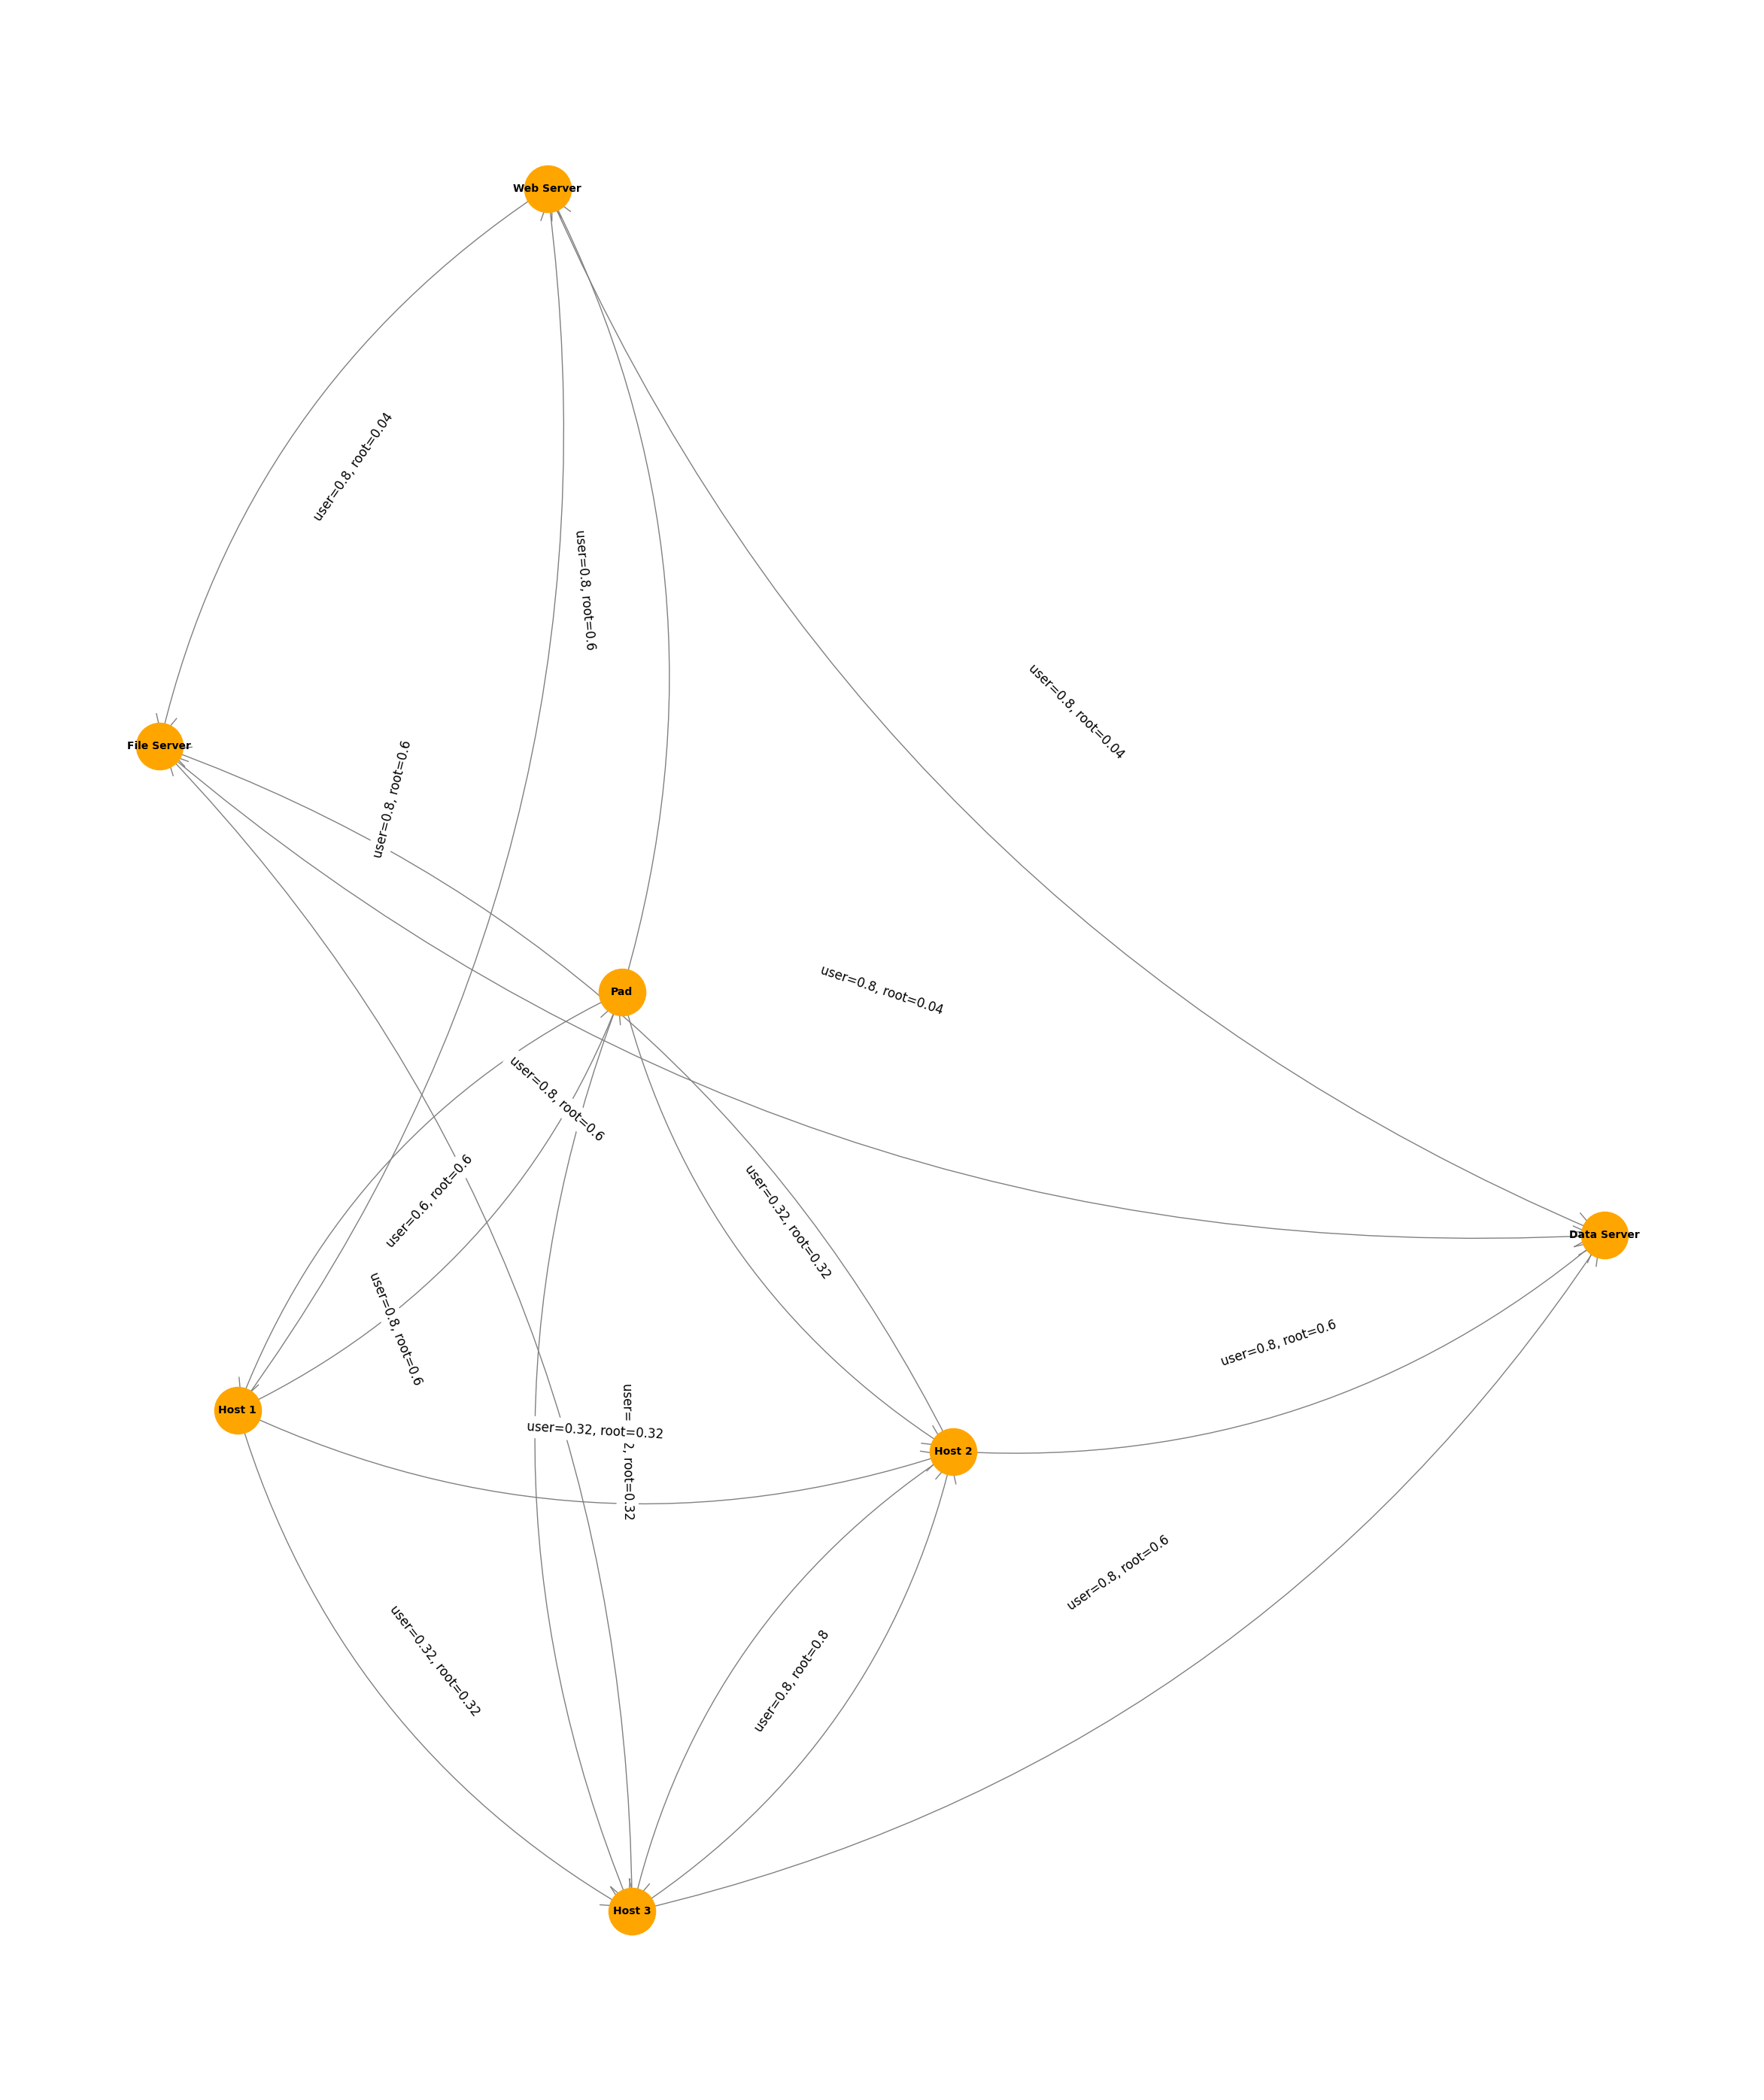

In [10]:
plt.figure(figsize=(30, 36))
pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=2000)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

nx.draw_networkx_edges(
    G, pos,
    edge_color='gray',
    arrows=True,
    arrowstyle='->',
    arrowsize=50,
    connectionstyle='arc3,rad=0.2'
)

# Vẽ nhãn trên cạnh
edge_labels = {(u, v): f"user={d['user']}, root={d['root']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

plt.axis('off')
plt.show()


In [11]:
# Initialize environment and train
algo = global_weighted_random_attack
# algo = greedy_attack_priority_queue
# Tạo một bản sao của đồ thị cho môi trường
G_new_env = deepcopy(G)

env = NetworkEnv(
    G_new=G_new_env,
    attack_fn=algo,
    g_dgl=g_dgl,
    encoder=encoder,
    original_node_features=original_node_features,
    original_edge_features=original_edge_features,
    node_map=node_map,
    goal="Data Server"  # (Hoặc goal bạn muốn)
)

# --- 3. HUẤN LUYỆN (Như cũ) ---
num_episode = 10000
model = train_dqn(env, num_episode)

node_to_idx đã được tải: {'Data Server': 0, 'Pad': 1, 'Web Server': 2, 'Host 1': 3, 'Host 2': 4, 'Host 3': 5, 'File Server': 6}
state_size (flattened): 168
action_space_size 105
Episode 1000, Total Reward: -36, Epsilon: 0.010, Defense Success Probability: 0.482%

Honeypot 0 -> File Server
Honeypot 1 -> Web Server

['Pad', 'Host 1', 'Web Server', 'Host 3', 'File Server', 'Honeypot {File Server}']
Saved model with best DSP 482 at episode 1000 to ./Saved_Model/dqn_model.pth
Episode 2000, Total Reward: 88, Epsilon: 0.010, Defense Success Probability: 0.544%

Honeypot 0 -> Host 1
Honeypot 1 -> Web Server

['Pad', 'Host 3', 'File Server', 'Web Server', 'Honeypot {Web Server}']
Episode 3000, Total Reward: 174, Epsilon: 0.010, Defense Success Probability: 0.587%

Honeypot 0 -> Host 1
Honeypot 1 -> Web Server

['Pad', 'Web Server', 'Honeypot {Web Server}']
Saved model with best DSP 587 at episode 3000 to ./Saved_Model/dqn_model.pth
Episode 4000, Total Reward: 140, Epsilon: 0.010, Defense Succes

In [12]:
evaluate_model(model,env)

TypeError: can only concatenate str (not "int") to str